In [3]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
from scipy.sparse import csr_matrix
import torch
from sklearn import metrics
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import itertools
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
def load_ctcf(ctcf_path, chrom, start=None):
    ctcf_all = pickle.load(open(ctcf_path, 'rb'))
    ctcf = ctcf_all['chr{}'.format(chrom)].toarray()[0]
    if start is not None:
        ctcf = ctcf[start*200: (start+700)*200]

    return ctcf


def load_atac(atac_path, chrom, start=None):
    atac_all = pickle.load(open(atac_path, 'rb'))
    atac = atac_all['chr{}'.format(chrom)].flatten()
    if start is not None:
        atac = atac[start*200: (start+700)*200]

    return atac


def process_scatac(scatac_pre, metacell, start):
    tmp = torch.tensor((metacell * scatac_pre)[:, start*20:(start+700)*20].toarray()).T

    size, eps = tmp.shape[1], 1e-8
    one, zero = torch.tensor(1.0), torch.tensor(0.0)
    lrg = torch.where(tmp>0, one, zero)
    eql = torch.where(tmp==0, one, zero)
    num, denom = lrg @ lrg.T, size - eql @ eql.T
    scatac = torch.div(num, torch.max(denom, eps * torch.ones_like(denom)))
    scatac[scatac != scatac] = 0

    scatac = scatac.reshape(
        scatac.shape[0]//20, 20, -1
    ).mean(axis=1).reshape(
        -1, scatac.shape[1]//20, 20
    ).mean(axis=2)

    return scatac


def load_scatac(scatac_path, metacell_path, chrom, start=None):
    scatac_pre = pickle.load(open(scatac_path, 'rb'))['chr{}'.format(chrom)]
    metacell = csr_matrix(pd.read_csv(metacell_path, index_col=0).values)

    if start is not None:
        scatac = process_scatac(scatac_pre, metacell, start)
        return scatac, metacell
    else:
        return scatac_pre, metacell


def load_multiome(input_dir, ct, chrom, start=None, genome='mm10'):
    ctcf_path = osp.join(input_dir, 'dna', '{}_ctcf_motif_score.p'.format(genome))
    atac_path = osp.join(input_dir, 'atac', '{}_tile_pbulk_50bp_dict.p'.format(ct))
    scatac_path = osp.join(input_dir, 'atac', '{}_tile_500bp_dict.p'.format(ct))
    metacell_path = osp.join(input_dir, 'atac', '{}_metacell_mask.csv'.format(ct))

    ctcf = load_ctcf(ctcf_path, chrom, start=start)
    atac = load_atac(atac_path, chrom, start=start)
    scatac, metacell = load_scatac(scatac_path, metacell_path, chrom, start=start)

    return ctcf, atac, scatac, metacell


def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]

In [21]:
input_dir = '/data/leslie/suny4/processed_input'
ct1, ct2 = 'mycGCB_am_gfp_myc_gcb_thelp_sample', 'mycGCB_am_gfp_myc_gcb_nothelp_sample'
ct3, ct4 = 'mycGCB_am_gfp_myc_gcb_thelp_sample', 'mycGCB_am_gfp_myc_gcb_thelp'
pred_dir = '/data/leslie/suny4/predictions/chromafold/'
chrom = 16

In [22]:
%%time

ctcf, atac1, scatac1, metacell1 = load_multiome(input_dir, ct1, chrom, start=None)
_, atac2, scatac2, metacell2 = load_multiome(input_dir, ct2, chrom, start=None)
_, atac3, scatac3, metacell3 = load_multiome(input_dir, ct3, chrom, start=None)
_, atac4, scatac4, metacell4 = load_multiome(input_dir, ct4, chrom, start=None)

CPU times: user 1.89 s, sys: 2.11 s, total: 4 s
Wall time: 5.2 s


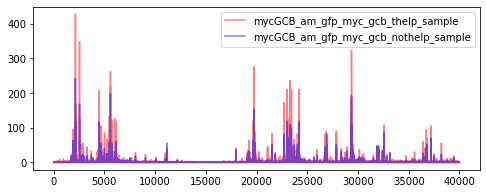

In [23]:
plt.figure(figsize=(8, 3))
plt.plot(atac1[2300*200:2500*200], alpha=0.5, color='red', label=ct1)
plt.plot(atac2[2300*200:2500*200], alpha=0.5, color='blue', label=ct2)
plt.legend()
plt.show()

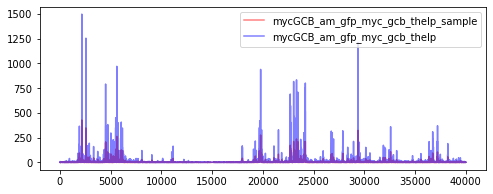

In [24]:
plt.figure(figsize=(8, 3))
plt.plot(atac3[2300*200:2500*200], alpha=0.5, color='red', label=ct3)
plt.plot(atac4[2300*200:2500*200], alpha=0.5, color='blue', label=ct4)
plt.legend()
plt.show()

In [25]:
%%time

pred1, pred2 = load_pred(pred_dir, ct1, chrom, avg_stripe=True), load_pred(pred_dir, ct2, chrom, avg_stripe=True)
pred3, pred4 = load_pred(pred_dir, ct3, chrom, avg_stripe=True), load_pred(pred_dir, ct4, chrom, avg_stripe=True)

CPU times: user 6.09 s, sys: 3.17 s, total: 9.25 s
Wall time: 9.41 s


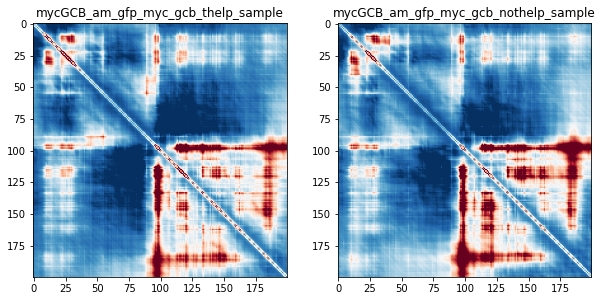

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1.set_title(ct1)
ax1.imshow(pred1[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
ax2.set_title(ct2)
ax2.imshow(pred2[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
plt.show()

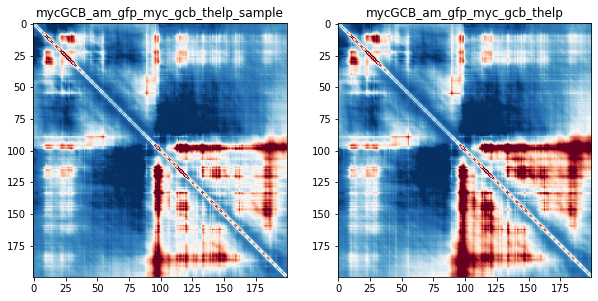

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 20))
ax1.set_title(ct3)
ax1.imshow(pred3[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
ax2.set_title(ct4)
ax2.imshow(pred4[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
plt.show()

In [28]:
def quantile_norm(pred1, pred2):
    if pred1.shape[0] - pred1.shape[1]:
        raise ValueError(
            'Matrix 1 is not square ({}, {})'.format(pred1.shape[0], pred1.shape[1])
        )
    if pred2.shape[0] - pred2.shape[1]:
        raise ValueError(
            'Matrix 2 is not square ({}, {})'.format(pred2.shape[0], pred2.shape[1])
        )
    if pred1.shape[0] - pred2.shape[0]:
        raise ValueError(
            'Matrix dimension mismatch ({} vs {})'.format(pred1.shape[0], pred2.shape[0])
        )
    l = pred1.shape[0]
    pred1_diag = np.array([
        np.pad(np.diagonal(pred1, offset=i), (0, i), 'constant') for i in range(200)
    ]).T
    pred2_diag = np.array([
        np.pad(np.diagonal(pred2, offset=i), (0, i), 'constant') for i in range(200)
    ]).T
    pred = np.column_stack((pred1_diag.ravel(), pred2_diag.ravel()))
    df, df_sort = pd.DataFrame(pred), pd.DataFrame(np.sort(pred, axis=0))
    df_mean = df_sort.mean(axis=1)
    df_mean.index += 1
    df_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack()
    pred1_stripe, pred2_stripe = df_qn[0].values.reshape(-1, 200), df_qn[1].values.reshape(-1, 200)

    pred1_qn, pred2_qn = np.zeros_like(pred1), np.zeros_like(pred2)
    for i in range(200):
        idx = np.arange(l - i, dtype=int)
        pred1_qn[idx, idx+i] = pred1_qn[idx+i, idx] = pred1_stripe[:l-i, i]
        pred2_qn[idx, idx+i] = pred2_qn[idx+i, idx] = pred2_stripe[:l-i, i]
    
    return pred1_qn, pred2_qn

In [29]:
%%time

pred1_qn, pred2_qn = quantile_norm(pred1, pred2)
pred3_qn, pred4_qn = quantile_norm(pred3, pred4)

CPU times: user 5.28 s, sys: 588 ms, total: 5.87 s
Wall time: 5.87 s


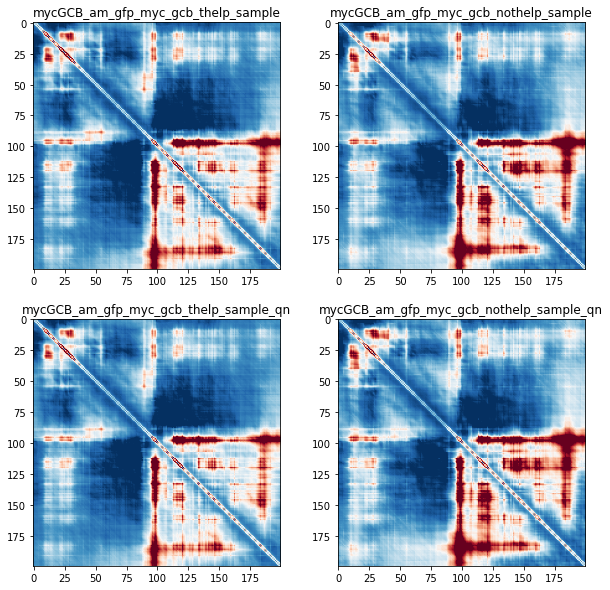

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].set_title(ct1)
axs[0][0].imshow(pred1[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
axs[0][1].set_title(ct2)
axs[0][1].imshow(pred2[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
axs[1][0].set_title(ct1+'_qn')
axs[1][0].imshow(pred1_qn[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
axs[1][1].set_title(ct2+'_qn')
axs[1][1].imshow(pred2_qn[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
plt.show()

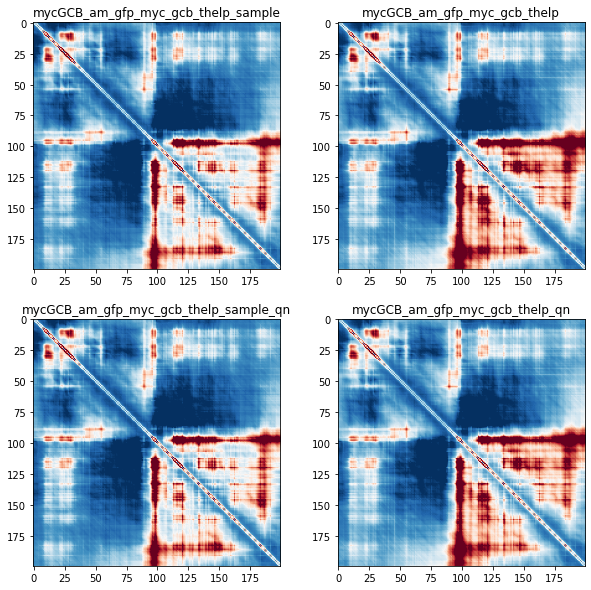

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0][0].set_title(ct3)
axs[0][0].imshow(pred3[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
axs[0][1].set_title(ct4)
axs[0][1].imshow(pred4[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
axs[1][0].set_title(ct3+'_qn')
axs[1][0].imshow(pred3_qn[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
axs[1][1].set_title(ct4+'_qn')
axs[1][1].imshow(pred4_qn[2300:2500, 2300:2500], cmap='RdBu_r', vmax=4, vmin=-1)
plt.show()